In [1]:
from fastbook import *
from fastai.vision.widgets import *

In [44]:
 def search_images_bing(key, term, max_images: int = 150, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [45]:
key = os.environ.get('AZURE_SEARCH_KEY', 'insert_your_key')

In [46]:
results = search_images_bing(key, 'bmw e36')
ims = results.attrgot('contentUrl')
len(ims)

150

In [47]:
bmw_types = 'E30', 'E36', 'E46', 'E90'
path = Path('BMWs')

In [51]:
if not path.exists():
    path.mkdir()
    for o in bmw_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'bmw {o}')
        download_images(dest, urls=results.attrgot('contentUrl'))


 Download of https://image.ibb.co/kTy7d6/IMG_9365_Edit.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p BMWs/E46
$ cd BMWs/E46
$ wget -c https://image.ibb.co/kTy7d6/IMG_9365_Edit.jpg
$ tar xf IMG_9365_Edit.jpg
 And re-run your code once the download is successful



In [52]:
fns = get_image_files(path)
fns

(#595) [Path('BMWs/E46/00000055.jpg'),Path('BMWs/E46/00000107.jpg'),Path('BMWs/E46/00000036.jpg'),Path('BMWs/E46/00000030.jpg'),Path('BMWs/E46/00000097.jpg'),Path('BMWs/E46/00000148.jpg'),Path('BMWs/E46/00000110.jpg'),Path('BMWs/E46/00000029.jpg'),Path('BMWs/E46/00000112.jpg'),Path('BMWs/E46/00000091.jpg')...]

In [53]:
failed = verify_images(fns)
failed

(#4) [Path('BMWs/E46/00000035.jpg'),Path('BMWs/E46/00000017.jpg'),Path('BMWs/E30/00000108.jpg'),Path('BMWs/E36/00000050.jpg')]

In [54]:
failed.map(Path.unlink);

In [55]:
# Creating data loader
model3 = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2,seed=50),
    get_y = parent_label,
    item_tfms=RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms=aug_transforms())

In [56]:
dls = model3.dataloaders(path)

In [57]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.111344,1.481833,0.491525,00:13


epoch,train_loss,valid_loss,error_rate,time
0,1.477361,1.000179,0.406780,00:13
1,1.274385,0.818916,0.322034,00:12
2,1.072285,0.702356,0.279661,00:13
3,0.911362,0.657462,0.271186,00:13


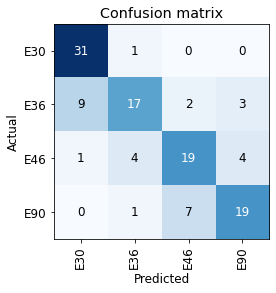

In [58]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [59]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [61]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [63]:
dls_clean = model3.dataloaders(path)
learn.dls = dls_clean
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.615058,1.743910,0.440678,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.576186,0.986124,0.279661,00:14
1,0.484208,0.547557,0.169492,00:13
2,0.404347,0.391371,0.144068,00:13
3,0.342643,0.331413,0.110169,00:14


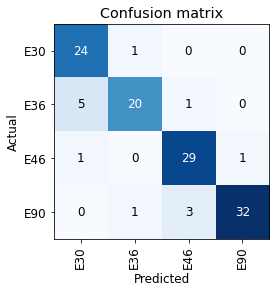

In [64]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

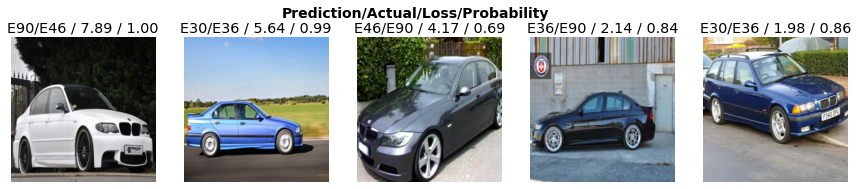

In [65]:
interp.plot_top_losses(5, nrows=1)

In [66]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [67]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [68]:
dls_clean_1 = model3.dataloaders(path)
learn.dls = dls_clean
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.236342,0.321657,0.101695,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.169460,0.371729,0.110169,00:14
1,0.218448,0.318912,0.101695,00:13
2,0.200861,0.344445,0.101695,00:13
3,0.194145,0.339471,0.093220,00:15


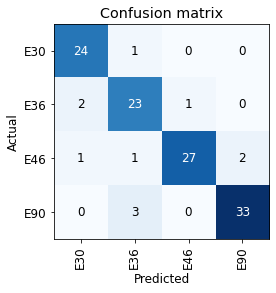

In [69]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
learn.export